### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import plotly.graph_objects as go

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 59.1       #  (submerged pipe weight) [kg/m]
N = 12       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 604.76664*1000
Fy_0 = 0.7*Fx_0
LTD = 255.21207

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 40 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.56870745, 0.12452548, 0.6224102 , 0.46142588, 0.74690681,
       0.11501631, 0.54762465, 0.13763751, 0.35969503, 0.37350202,
       0.36330459, 0.90067854])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 50)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1
vessel_motion_calibration_coefficient = 1e3

In [33]:
# Tp=10
# z_acceleration_factor=1e-06

### Main functions:

In [34]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [35]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [36]:
Π(φ,θ,ψ)

array([[[ 0.98544919,  0.        ,  0.14321659],
        [ 0.        ,  1.        , -0.5385434 ],
        [-0.1699703 ,  0.        ,  0.83033729]],

       [[ 0.97161655,  0.        ,  0.2347296 ],
        [ 0.        ,  1.        , -0.1242039 ],
        [-0.23656137,  0.        ,  0.96409305]],

       [[ 0.97156267,  0.        ,  0.19238008],
        [ 0.        ,  1.        , -0.58299508],
        [-0.23678257,  0.        ,  0.78937104]],

       [[ 0.99990928,  0.        ,  0.01206083],
        [ 0.        ,  1.        , -0.44522532],
        [-0.01346949,  0.        ,  0.89533734]],

       [[ 0.93171459,  0.        ,  0.26650752],
        [ 0.        ,  1.        , -0.67937225],
        [-0.3631913 ,  0.        ,  0.68368639]],

       [[ 0.97370508,  0.        ,  0.22630707],
        [ 0.        ,  1.        , -0.11476289],
        [-0.22781225,  0.        ,  0.96727172]],

       [[ 0.91828803,  0.        ,  0.33801613],
        [ 0.        ,  1.        , -0.52066071],
        

In [37]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [38]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.37543785,  0.33566829,  0.41709257],
       [ 0.36114943,  0.87739933,  0.27896594],
       [ 0.62680266, -0.04660841,  0.45098047],
       [ 0.95711774, -0.0541903 ,  0.66179625],
       [ 0.70907453,  0.26171631,  0.16577324],
       [ 0.71270738,  0.22541601,  0.80722706],
       [ 0.32563489, -0.07033473,  0.46881275],
       [ 1.14639328,  0.4786269 ,  0.54427407],
       [ 0.62143778,  0.36488612,  0.18981404],
       [ 0.66210946,  0.2886679 ,  0.34955871],
       [ 0.51219281, -0.21378321,  0.47045143],
       [ 0.3355621 , -0.49982662,  0.33891776]])

In [39]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [40]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 0.6322271 ,  0.9299364 ,  0.60216495],
       [ 1.43356055,  0.9050358 ,  0.71071426],
       [ 1.49612884,  0.10243441,  0.5957406 ],
       [ 1.17571383, -0.40706641,  0.64379912],
       [ 1.02443272,  0.24477718,  0.12048771],
       [ 0.92002   ,  0.82930579,  0.74225283],
       [ 1.06875453,  0.1538796 ,  0.38056652],
       [ 1.38326436,  0.12038467,  0.76169611],
       [ 1.23094062,  0.96123377,  0.17405456],
       [ 0.87360267,  0.32538238,  0.521338  ],
       [ 1.235863  , -0.4539046 ,  1.1197182 ],
       [ 0.96436706, -0.66661135,  0.99809945]])

In [41]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [42]:
phi(x,y,z)

array([[0.99012411, 0.86342162, 0.83150468],
       [0.49658839, 0.55211285, 0.44426932],
       [0.28937223, 0.17225702, 0.27639115],
       [0.34172876, 0.04966788, 0.64347086],
       [0.23553884, 0.60578943, 0.73978808],
       [0.78603449, 0.58835005, 0.94178416],
       [0.13090841, 0.17445919, 0.55714215],
       [0.51225162, 0.54759686, 0.34574618],
       [0.06833348, 0.43351704, 0.30580476],
       [0.54402076, 0.24516837, 0.51398234],
       [0.38086091, 0.49593473, 0.04411064],
       [0.31484681, 0.305565  , 0.98380311]])

In [43]:
theta(φ,θ,ψ)

array([[0.56870745, 0.17079953, 0.15767294],
       [0.12452548, 0.23882523, 0.43260661],
       [0.6224102 , 0.23905291, 0.85027227],
       [0.46142588, 0.0134699 , 0.63181173],
       [0.74690681, 0.3716908 , 0.39646003],
       [0.11501631, 0.22983026, 0.32068543],
       [0.54762465, 0.40706186, 0.57573462],
       [0.13763751, 0.30651907, 0.3216625 ],
       [0.35969503, 0.18212483, 0.12933905],
       [0.37350202, 0.35466259, 0.36637985],
       [0.36330459, 0.29024163, 0.40253245],
       [0.90067854, 0.32089556, 0.0967085 ]])

In [44]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [45]:
ω(x,y,z)

array([[ 9.90130465e-01,  1.68205490e-01, -4.56138109e-01],
       [ 6.27673051e-01,  3.40450151e-01,  7.21159542e-02],
       [ 3.30495137e-01,  9.33886349e-02,  2.11379036e-01],
       [ 3.71406772e-01, -1.65969748e-01,  5.88549668e-01],
       [ 6.03237923e-01,  4.33147318e-01,  4.57234796e-01],
       [ 1.02322408e+00, -7.80155432e-02,  1.17375512e-01],
       [ 2.24800114e-01,  1.01732734e-01,  5.21267840e-01],
       [ 5.94252192e-01,  3.78132451e-01, -9.39634790e-03],
       [ 1.90170332e-01,  4.12636594e-01,  2.48163799e-01],
       [ 6.34496123e-01, -2.08588507e-02,  2.94585503e-01],
       [ 3.54462590e-01,  4.79537932e-01, -1.45217752e-01],
       [ 5.81673474e-01,  9.09881932e-04,  7.97394702e-01]])

In [46]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [47]:
Ret(φ,θ,ψ)

array([[[ 0.98759812, -0.06433476,  0.14321659],
        [ 0.13230507,  0.83214564, -0.5385434 ],
        [-0.08453   ,  0.55081273,  0.83033729]],

       [[ 0.8944254 , -0.38066419,  0.2347296 ],
        [ 0.41599242,  0.9008461 , -0.1242039 ],
        [-0.16417527,  0.20873686,  0.96409305]],

       [[ 0.74475008, -0.63901269,  0.19238008],
        [ 0.61054304,  0.53605404, -0.58299508],
        [ 0.26941513,  0.55164196,  0.78937104]],

       [[ 0.81042746, -0.58571484,  0.01206083],
        [ 0.52884112,  0.7225659 , -0.44522532],
        [ 0.25206033,  0.36720109,  0.89533734]],

       [[ 0.95472577, -0.13218337,  0.26650752],
        [ 0.28335842,  0.67687617, -0.67937225],
        [-0.09059088,  0.72413135,  0.68368639]],

       [[ 0.93230635, -0.28211697,  0.22630707],
        [ 0.31313445,  0.94274933, -0.11476289],
        [-0.18097428,  0.17785871,  0.96727172]],

       [[ 0.88248433, -0.32705733,  0.33801613],
        [ 0.4648326 ,  0.71613063, -0.52066071],
        

In [48]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [49]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.04183505, -0.45085859,  0.41834901],
       [-0.13177578,  0.09361898,  0.03094988],
       [-0.16116523, -0.06077299,  0.20661051],
       [-0.20012762, -0.11060373,  0.11481921],
       [ 0.07584567, -0.59303798,  0.46147207],
       [ 0.01470596,  0.04940351, -0.04313722],
       [ 0.01885907, -0.35789165,  0.10763622],
       [-0.05288207,  0.05572211, -0.00990416],
       [ 0.01840091, -0.11119853,  0.15352626],
       [ 0.06695239, -0.13745001, -0.00530192],
       [-0.12073878,  0.07760446,  0.16998016],
       [ 0.31052174, -0.93099557,  0.18978683]])

In [50]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.00769056, -0.0724425 ,  0.05073456],
       [-0.01249946, -0.04800284,  0.03009846],
       [-0.34344075, -0.32723104,  0.3434036 ],
       [-0.1767533 , -0.03816866,  0.12990052],
       [ 0.04065662, -0.31794904,  0.22149023],
       [-0.0033679 , -0.02652419,  0.02021739],
       [-0.03370636, -0.27311265,  0.22515961],
       [ 0.0040186 , -0.03704039,  0.03357705],
       [ 0.0078489 , -0.02919734,  0.01928538],
       [ 0.01351154, -0.10069561,  0.08370105],
       [-0.01521023, -0.09026406,  0.07881187],
       [ 0.09657591, -0.28902543,  0.05959273]])

In [51]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [52]:
ne(x, y, z, φ, θ, ψ)

array([[ 4.18350527e+07, -4.50858587e+08,  4.18349008e+08],
       [-1.31775780e+08,  9.36189806e+07,  3.09498776e+07],
       [-1.61165232e+08, -6.07729940e+07,  2.06610507e+08],
       [-2.00127616e+08, -1.10603728e+08,  1.14819208e+08],
       [ 7.58456724e+07, -5.93037978e+08,  4.61472067e+08],
       [ 1.47059634e+07,  4.94035116e+07, -4.31372226e+07],
       [ 1.88590720e+07, -3.57891647e+08,  1.07636223e+08],
       [-5.28820713e+07,  5.57221124e+07, -9.90416489e+06],
       [ 1.84009125e+07, -1.11198533e+08,  1.53526256e+08],
       [ 6.69523889e+07, -1.37450008e+08, -5.30192408e+06],
       [-1.20738775e+08,  7.76044570e+07,  1.69980159e+08],
       [ 3.10521738e+08, -9.30995572e+08,  1.89786835e+08]])

In [53]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 5.13759113e+07, -2.42469994e+08, -2.66449760e+08],
       [-3.05595005e+07, -5.79657634e+07,  4.52245296e+07],
       [-2.11937637e+07, -2.43155014e+08, -8.80543603e+07],
       [ 3.11275311e+07, -1.65815980e+08, -1.05473529e+08],
       [ 4.71022835e+07, -3.69915553e+08, -4.83120197e+08],
       [-2.23566648e+07,  1.21379508e+07,  6.27952108e+06],
       [ 9.54980891e+07, -7.06509493e+07, -2.51647533e+08],
       [-1.72111974e+07, -1.16158725e+07,  2.65446731e+07],
       [ 2.69664374e+07, -5.66836034e+07, -4.42878032e+07],
       [ 2.49689493e+07,  1.52182714e+07, -7.92204316e+07],
       [ 5.11097844e+06, -1.08450401e+08,  5.31434246e+07],
       [-1.64904252e+08, -2.36323501e+08, -8.89470432e+08]])

In [54]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [55]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 5.83013678e+10,  8.58858058e+09,  3.42583463e+09],
       [ 2.22536594e+10,  1.85093804e+10,  3.87615106e+10],
       [ 7.68285965e+10, -2.56651645e+10,  5.23804420e+10],
       [ 4.69004196e+10, -2.67828684e+10,  5.59469463e+10],
       [ 8.01563556e+10,  1.02346861e+10, -2.15726231e+07],
       [ 1.84565342e+10,  1.93027471e+10,  2.83987826e+10],
       [ 6.97484746e+10,  1.07299468e+10,  2.34564792e+10],
       [ 2.27363306e+10,  2.62385891e+10,  2.62238520e+10],
       [ 3.75672745e+10,  1.36598931e+10,  5.39118172e+09],
       [ 4.68718702e+10,  2.20978559e+10,  1.90182316e+10],
       [ 4.55788266e+10,  1.47195660e+10,  2.56549224e+10],
       [ 8.73646930e+10,  2.45100420e+10, -2.27091397e+10]])

In [56]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 1.78813934e-07, -1.18204488e-06,  0.00000000e+00],
       [ 9.53674316e-07,  6.62954012e-07, -9.53674316e-07],
       [-1.90734863e-06,  9.01965244e-06,  3.81469727e-06],
       [-1.90734863e-06, -4.01778152e-06, -1.90734863e-06],
       [ 1.55530870e-07, -1.22357113e-06, -1.90734863e-06],
       [-9.53674316e-07, -1.12706402e-06,  9.53674316e-07],
       [-9.53674316e-07,  1.40437362e-06,  9.53674316e-07],
       [-2.86102295e-06,  9.35872465e-07,  9.53674316e-07],
       [ 1.19209290e-07,  2.50832130e-08, -9.53674316e-07],
       [ 9.53674316e-07, -1.75829167e-06,  0.00000000e+00],
       [ 9.53674316e-07, -3.05111475e-07, -1.90734863e-06],
       [ 9.53674316e-07, -1.75809905e-06,  3.81469727e-06]])

In [57]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [58]:
fD(dx,dy,dz).T

array([[3.66347134e+03, 2.10244363e+02, 4.41492643e+02],
       [1.16788017e+03, 1.14274387e+02, 2.79206126e+03],
       [6.02781995e+02, 4.13123780e-01, 6.02040648e+00],
       [3.07945534e+03, 1.81048981e+02, 5.21236872e+02],
       [2.14486910e+03, 1.48994848e+02, 1.57397344e+03],
       [2.57771980e+03, 3.41429569e+03, 9.65702685e+02],
       [1.60193210e+03, 1.16212252e+03, 1.09510683e+03],
       [6.96303623e+02, 5.79710184e+02, 9.56632065e+02],
       [1.32377362e+03, 1.10417412e+03, 1.71763021e+03],
       [3.10076290e+03, 1.05607333e+03, 6.77444332e+02],
       [5.17610471e+02, 3.06579312e+03, 2.33723434e+03],
       [1.45144902e+03, 2.32179737e+03, 2.76328324e+03]])

In [59]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [60]:
fg_e

array([[  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414]])

In [61]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [62]:
sigma(x,y,z)

array([[ 3958.1362412 ,  3958.1362412 , 17597.62572318],
       [ 3958.1362412 ,  3958.1362412 , 11245.65599205],
       [ 3958.1362412 ,  3958.1362412 ,  8491.88611197],
       [ 3958.1362412 ,  3958.1362412 , 14513.23497801],
       [ 3958.1362412 ,  3958.1362412 , 16093.16324765],
       [ 3958.1362412 ,  3958.1362412 , 19406.58221274],
       [ 3958.1362412 ,  3958.1362412 , 13097.15216375],
       [ 3958.1362412 ,  3958.1362412 ,  9629.54317855],
       [ 3958.1362412 ,  3958.1362412 ,  8974.36882216],
       [ 3958.1362412 ,  3958.1362412 , 12389.18525187],
       [ 3958.1362412 ,  3958.1362412 ,  4681.69996956],
       [ 3958.1362412 ,  3958.1362412 , 20095.83518228]])

In [63]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [64]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-3.66347134e+03, -2.10244363e+02, -6.82043277e+02],
       [-1.16788017e+03, -1.14274387e+02, -3.03261189e+03],
       [-6.02781995e+02, -4.13123780e-01, -2.46571041e+02],
       [-3.07945534e+03, -1.81048981e+02, -7.61787506e+02],
       [-2.14486910e+03, -1.48994848e+02, -1.81452407e+03],
       [-2.57771980e+03, -3.41429569e+03, -1.20625332e+03],
       [-1.60193210e+03, -1.16212252e+03, -1.33565746e+03],
       [-6.96303623e+02, -5.79710184e+02, -1.19718270e+03],
       [-1.32377362e+03, -1.10417412e+03, -1.95818084e+03],
       [-3.10076290e+03, -1.05607333e+03, -9.17994966e+02],
       [-5.17610471e+02, -3.06579312e+03, -2.57778497e+03],
       [-1.45144902e+03, -2.32179737e+03, -3.00383387e+03]])

In [65]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [66]:
RET = Ret(φ, θ, ψ)

In [67]:
Jrho(RET,Jrho0)

array([[[  94.26260332,    4.06982694,   41.39236521],
        [  33.18074813,    9.06814329, -132.35435991],
        [ -15.09831833,  137.85153343,  107.0177363 ]],

       [[  56.45697798,  -58.5402126 ,   70.98304562],
        [  78.76017482,   60.13184204,  -25.37310984],
        [ -37.65700602,   65.30189405,  179.44880786]],

       [[  26.816815  ,  -60.62002368,   81.95348719],
        [  46.78506442,  -74.59999066, -111.54594161],
        [  96.27851061,   99.44505793,   97.64388358]],

       [[  35.31226817,  -88.90394637,   29.21465292],
        [  58.62626373,  -11.4623048 , -111.25800797],
        [  84.98257037,   77.52291929,  144.28107375]],

       [[  82.57597253,   17.03022561,   70.86584478],
        [  58.5418008 ,  -56.3203414 , -131.32888638],
        [  -0.51722226,  149.22793584,   41.87562743]],

       [[  69.89430604,  -44.84836626,   68.1164939 ],
        [  62.86827963,   75.96125915,  -25.93418847],
        [ -46.31323902,   56.2807495 ,  180.98618402]],

### Static solution

In [68]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [69]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [70]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [71]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [72]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [73]:
delta_x=horizontal_length/(N-1)

In [74]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [75]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [76]:
length_p1

[0,
 23.26045397959677,
 46.53247371134786,
 69.82763069727322,
 93.15750794198678,
 116.53370571115184,
 139.96784729853016,
 163.471584804496,
 187.05660492889174,
 210.73463478110844,
 234.5174477102832,
 258.41686915851545]

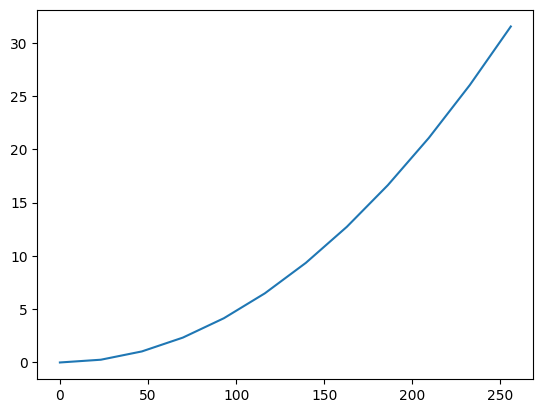

In [77]:
plt.plot(x0, z0)
plt.show()

In [78]:
q0=np.zeros(12*N)

In [79]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [80]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [81]:
root_ = root(static_func, q0, method='df-sane')

In [82]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.259e+01  1.259e+01 ...  0.000e+00  0.000e+00]
       x: [-5.142e+02 -4.909e+02 ...  0.000e+00  0.000e+00]
     nit: 291
    nfev: 1000
  method: df-sane

In [83]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [84]:
# q0 = root_.x                                            # start from static solution

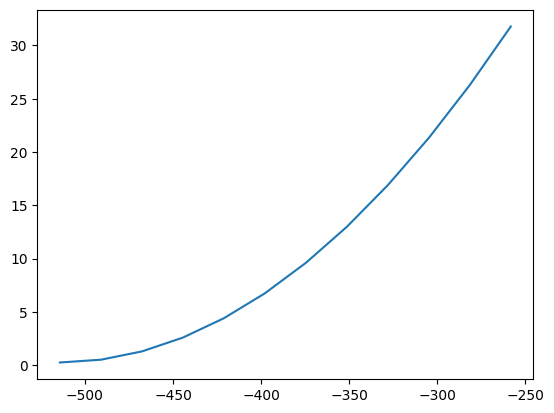

In [85]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [86]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [87]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [88]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [89]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [90]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [91]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [92]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [93]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [94]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [95]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.16474247e-04, -1.81579590e-03,  3.98635864e-04],
       [-6.45637512e-04, -1.01089478e-03,  6.56127930e-04],
       [-4.42981720e-04, -5.60760498e-04, -4.36782837e-04],
       [-1.03968382e-03, -1.67846680e-03,  6.44207001e-04],
       [ 1.78337097e-04, -2.38037109e-03, -1.25885010e-04],
       [-5.03540039e-04,  1.15966797e-03, -1.67846680e-04],
       [ 2.13623047e-04,  8.44955444e-04,  3.05175781e-05],
       [ 5.85347414e-04,  2.84576416e-03,  2.07938254e-04],
       [-1.15648319e-03,  2.20081913e-03, -1.64108206e-04],
       [ 8.40652655e-04,  1.67230745e-03,  2.13692840e-04],
       [ 1.51490923e+07, -2.33602450e+04, -3.44288014e+07]])

In [96]:
mom

array([[ 1.46865845e-03, -6.39304519e-04,  4.27246094e-04],
       [ 8.41140747e-04, -5.21850586e-03, -6.94274902e-04],
       [ 2.46715546e-03, -1.54266357e-02, -5.43212891e-03],
       [ 3.46374512e-03, -5.49316406e-04, -2.50244141e-03],
       [ 3.38745117e-03, -9.65118408e-04, -1.34277344e-03],
       [ 7.04765320e-04, -2.38037109e-03,  6.39343262e-03],
       [ 7.70568848e-04,  2.87103653e-03, -7.93457031e-04],
       [-8.43048096e-04,  3.23486328e-03, -6.74438477e-03],
       [-1.25122070e-03,  2.12097168e-03, -5.31005859e-03],
       [-1.83211911e-03,  1.16527999e-03,  1.61545225e-03],
       [-2.01975402e-04, -2.29556408e-03,  7.72347569e-04],
       [-7.36647817e+05, -9.28629293e+09,  5.97669638e+06]])

In [97]:
angle

array([[-0.37831495,  0.02453155, -0.04186598],
       [-0.37831495,  0.02394308, -0.04186578],
       [-0.37653461,  0.02217103, -0.04180563],
       [-0.37119622,  0.01920124, -0.04150689],
       [-0.36052738,  0.01501772, -0.04067201],
       [-0.34276358,  0.00960261, -0.03888476],
       [-0.31615077,  0.00293612, -0.03561056],
       [-0.27894784, -0.0050035 , -0.03019691],
       [-0.22942909, -0.01424002, -0.02187387],
       [-0.16588652, -0.02479927, -0.00975464],
       [-0.08663213, -0.03670922,  0.0071638 ],
       [ 0.01      , -0.05      ,  0.03      ]])

### Vessle Simulation

In [98]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [99]:
Number*sampleTime

600.0

In [100]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [101]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [102]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

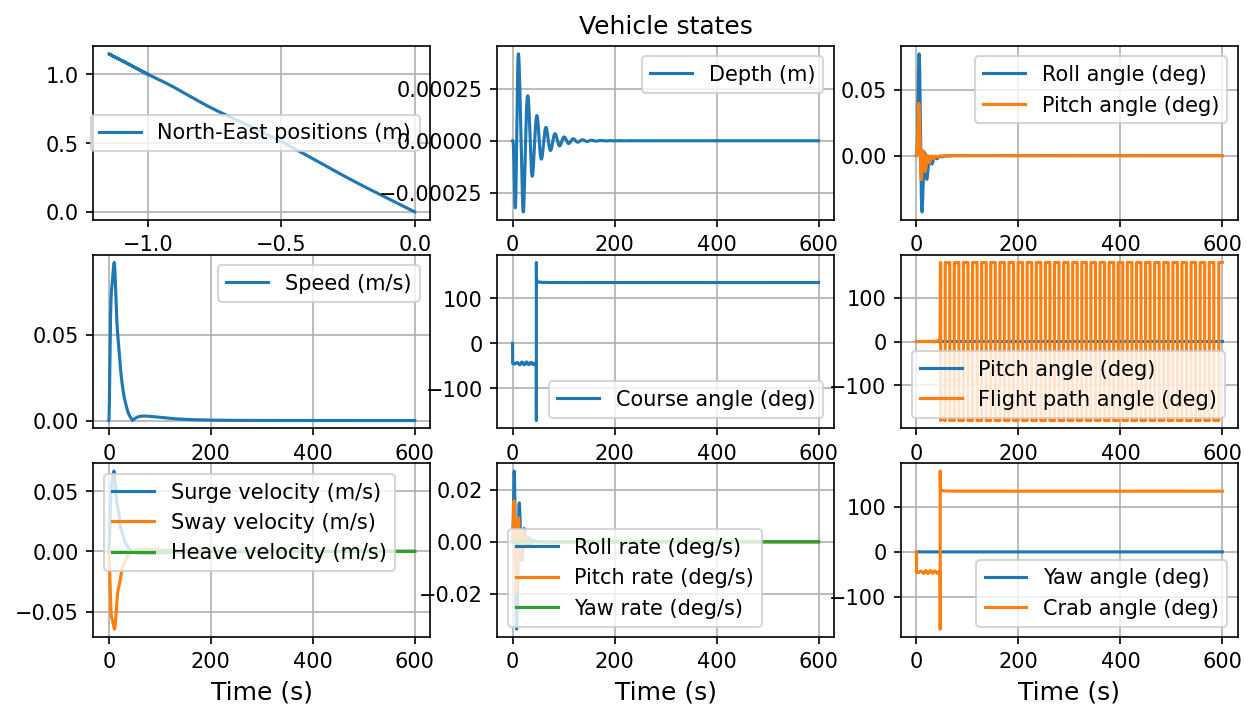

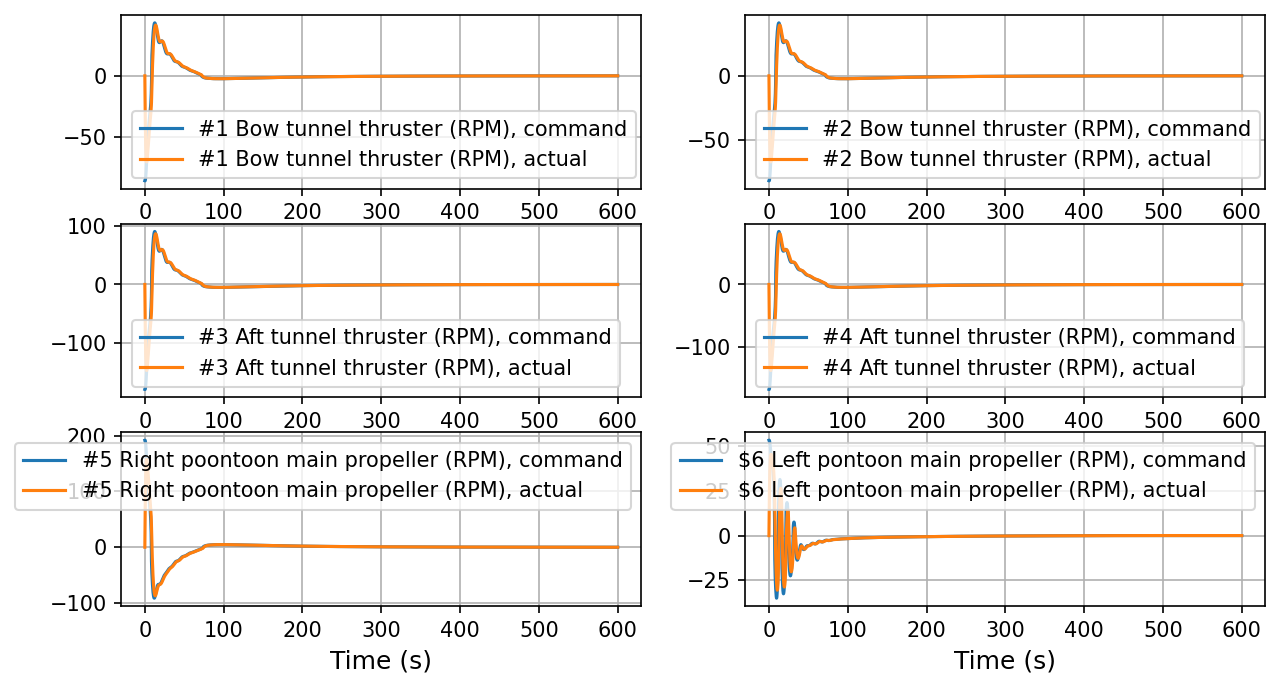

In [103]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [104]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

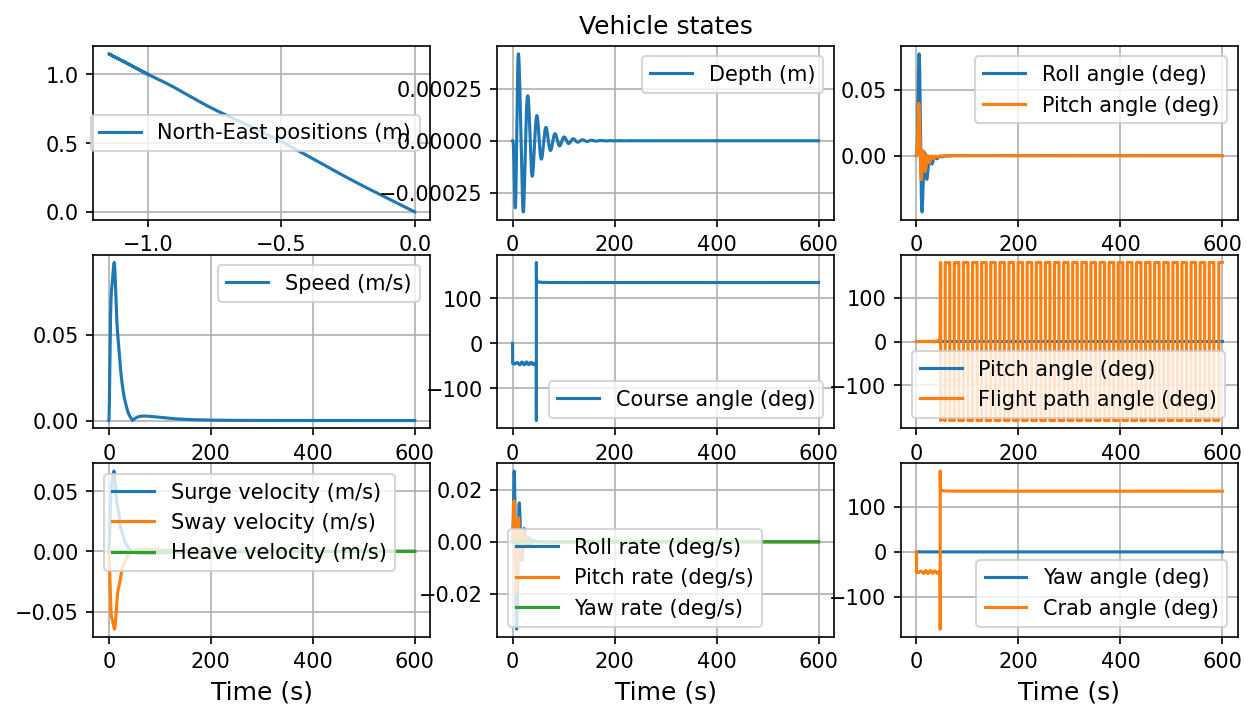

In [105]:
plotVehicleStates(simTime, simData, 3)

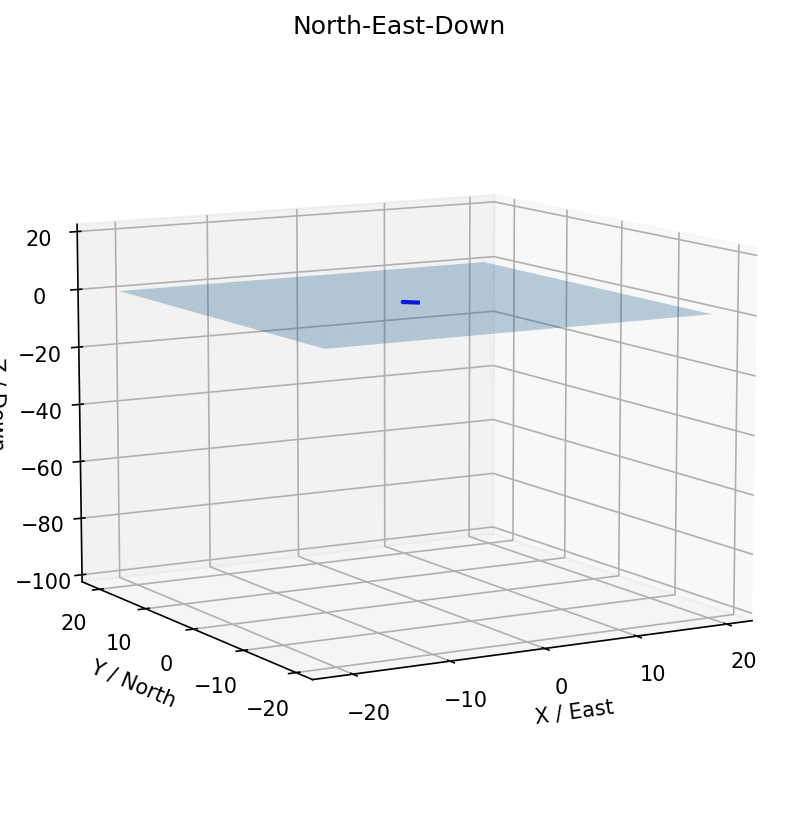

In [106]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [107]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [108]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.max_bending_strain = 0
        self.max_bending_strain1 = 0
        self.my_iter = 0

In [109]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [110]:
# V_rho=np.zeros(Jrho0.shape)
# np.fill_diagonal(V_rho, vessel_inertia)

In [111]:
# M_t=inert(vessel_mass*9.81,mp*9.81, x0)
# Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [112]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
        
        
    nz = np.linalg.norm(ddz)
    ddz = ddz / nz  
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    ax=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ)))/(mp*9.81*h)
    W = 3.14*(d0**4-dI**4)/(32*d0)
    T.max_bending_strain=max(T.max_bending_strain,(ax*12/W)/E)
    
    ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*1**2)
    T.max_bending_strain1=max(T.max_bending_strain1,(ben/W)/E)
    
    T.my_iter+=1
    
    return ans

In [113]:
T_ = MyTime()

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.001257*i/N for i in range(N)]))

In [114]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  6.02338632167274e-07  Iteration wall clock time:  0:00:00.014964
Physical time:  1.0057298485158144  Iteration wall clock time:  0:00:01.083979
Physical time:  2.001979677404559  Iteration wall clock time:  0:00:00.707045
Physical time:  3.003345591329297  Iteration wall clock time:  0:00:01.069832
Physical time:  4.03811780196004  Iteration wall clock time:  0:00:00.797474
Physical time:  5.031770569237814  Iteration wall clock time:  0:00:00.681105
Physical time:  6.022821661669806  Iteration wall clock time:  0:00:00.936571
Physical time:  7.053722248808748  Iteration wall clock time:  0:00:00.626234
Physical time:  8.007025592082256  Iteration wall clock time:  0:00:00.741208
Physical time:  9.000933456366813  Iteration wall clock time:  0:00:00.654550
Physical time:  10.00026102071678  Iteration wall clock time:  0:00:00.641928
Physical time:  11.0146795676136  Iteration wall clock time:  0:00:00.887966
Physical time:  12.003517010914406  Iteration wall clock time:

In [115]:
# max bending strain
T_.max_bending_strain*mp*9.81*h

0.16094440422790374

In [116]:
T_.max_bending_strain1*mp*9.81*1**2

1.2305355305562433

In [117]:
# axial tension
W = 3.14*(d0**4-dI**4)/(32*d0)
T_.max_bending_strain*mp*9.81*h*W*E/12

10899369.587300561

### Results

In [118]:
fin=us_

In [119]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.023e-05 ...  4.994e+01  5.000e+01]
        y: [[ 0.000e+00  6.803e-26 ...  4.690e-04  4.702e-04]
            [ 2.326e+01  2.326e+01 ...  2.256e+01  2.256e+01]
            ...
            [ 0.000e+00 -1.171e-18 ... -2.135e-13 -2.188e-13]
            [ 0.000e+00 -2.720e-18 ... -5.090e-14 -4.933e-14]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3356
     njev: 0
      nlu: 0

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

In [122]:
t.shape, fin.shape

((428,), (428, 144))

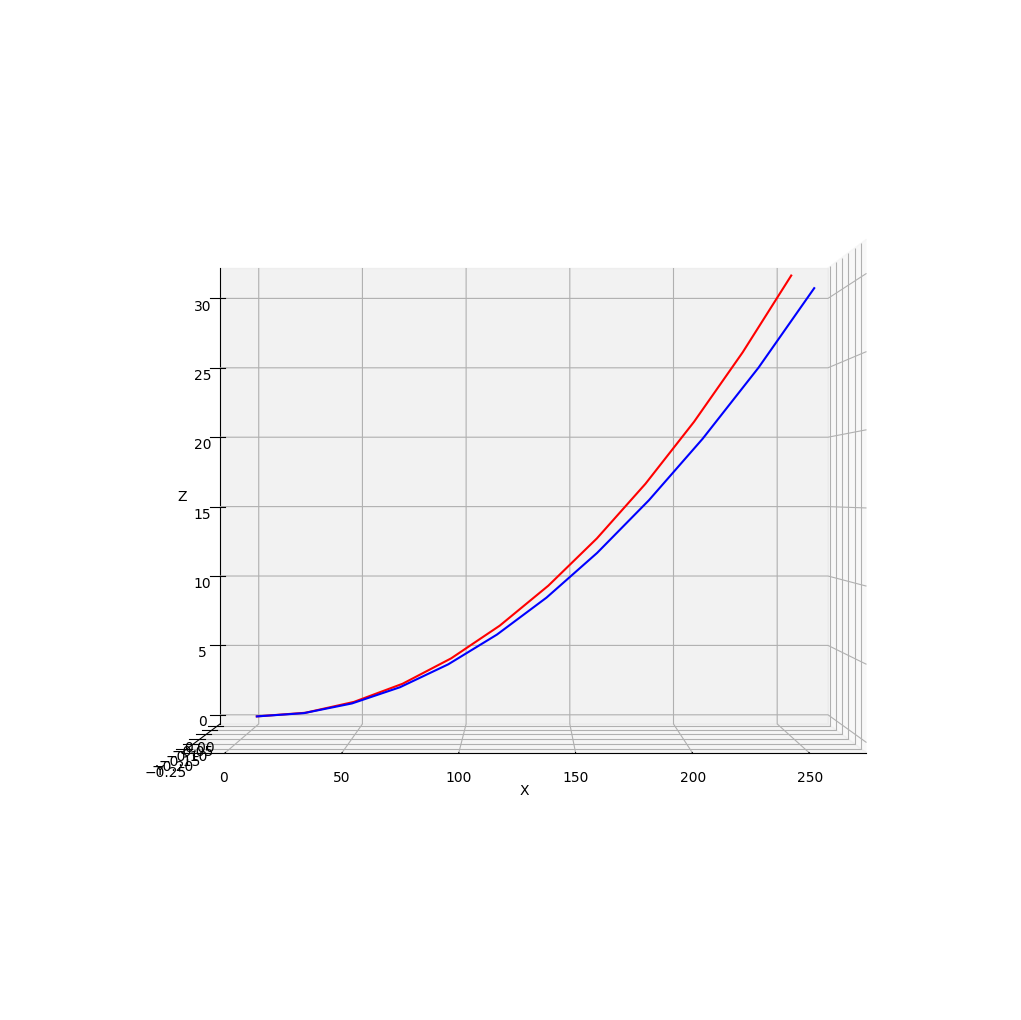

In [123]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [124]:
X,Y,Z

(array([4.70216444e-04, 2.25594229e+01, 4.56906927e+01, 6.88660618e+01,
        9.20312443e+01, 1.15194042e+02, 1.38407332e+02, 1.61570405e+02,
        1.84654744e+02, 2.07888065e+02, 2.31094786e+02, 2.53130871e+02]),
 array([ 4.70174286e-08, -1.07043163e-04, -5.00060586e-03, -1.47526402e-02,
        -2.93582740e-02, -4.88143246e-02, -7.31501839e-02, -1.02315488e-01,
        -1.36277437e-01, -1.75202218e-01, -2.18972656e-01, -2.66351231e-01]),
 array([-1.69719482e-03,  2.34236922e-01,  9.53350881e-01,  2.16060501e+00,
         3.85493132e+00,  6.03077525e+00,  8.69425386e+00,  1.18453436e+01,
         1.54704776e+01,  1.95942565e+01,  2.42045608e+01,  2.91622664e+01]))

In [125]:
X0,Y0,Z0

(array([  0.        ,  23.2590084 ,  46.51801679,  69.77702519,
         93.03603358, 116.29504198, 139.55405037, 162.81305877,
        186.07206716, 209.33107556, 232.59008395, 255.84909235]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  0.25932181,  1.03741619,  2.33467001,  4.15172827,
         6.48949443,  9.34913084, 12.73205933, 16.63996193, 21.07478168,
        26.03872359, 31.53425578]))

In [126]:
us=fin.T

In [127]:
us.shape

(144, 428)

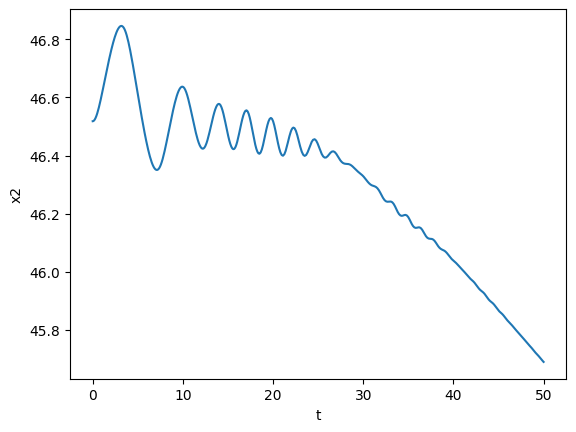

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

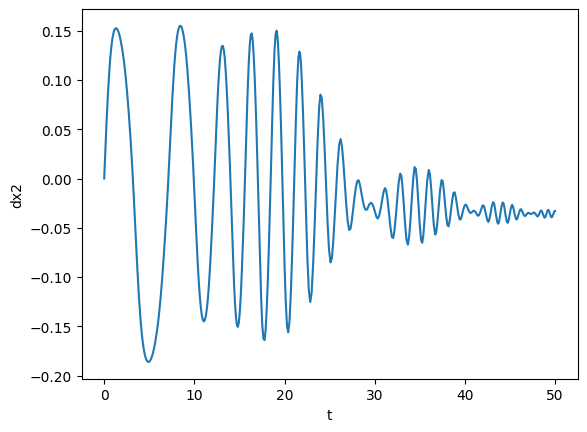

In [129]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

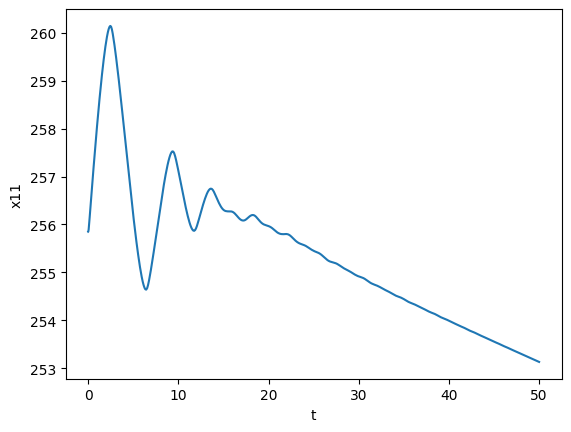

In [130]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

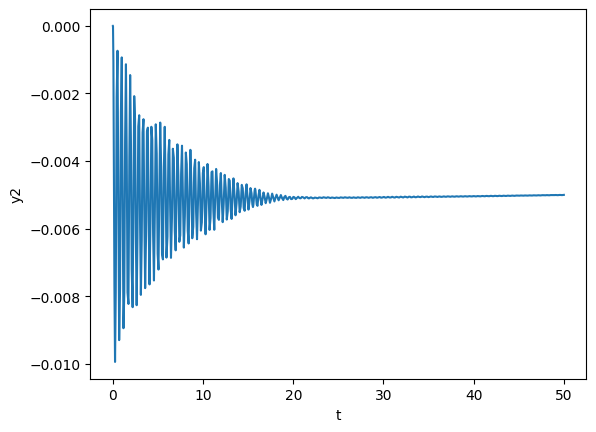

In [131]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

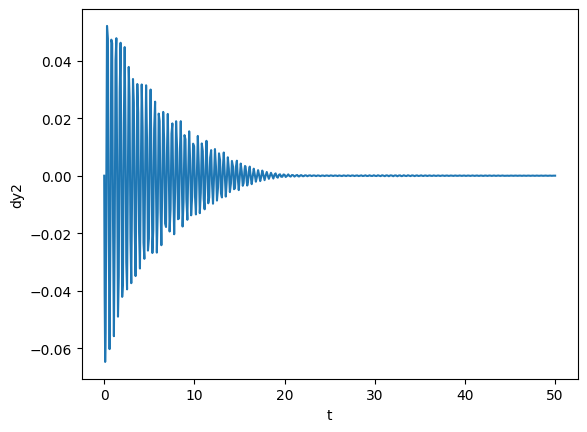

In [132]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

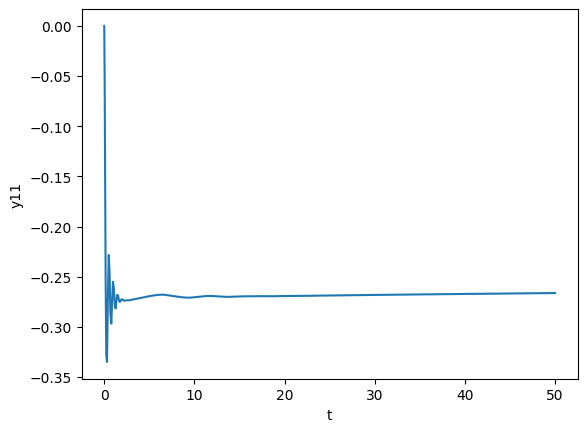

In [133]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

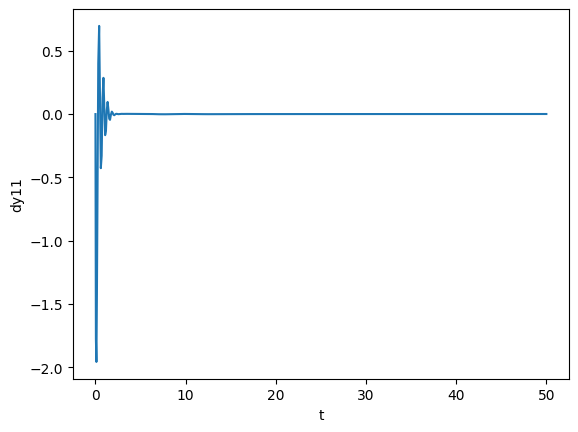

In [134]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

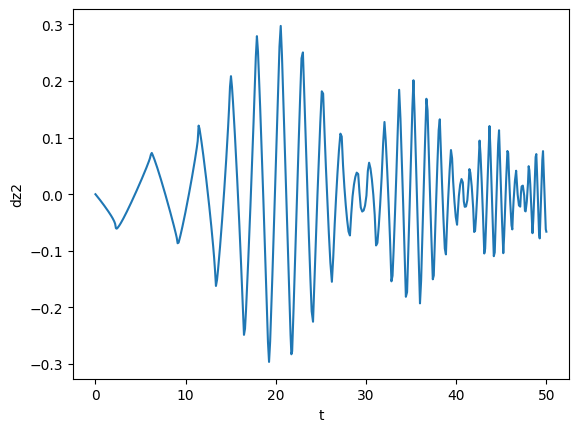

In [135]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

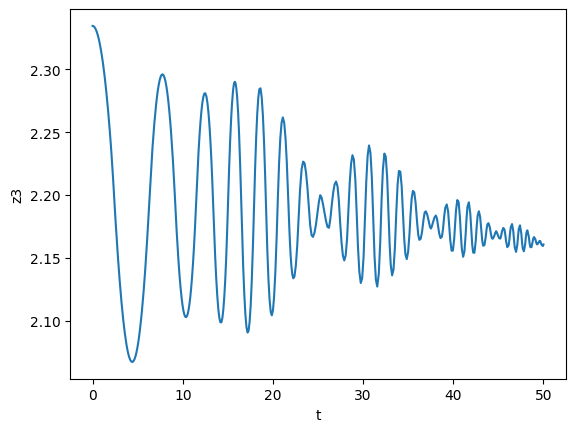

In [136]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

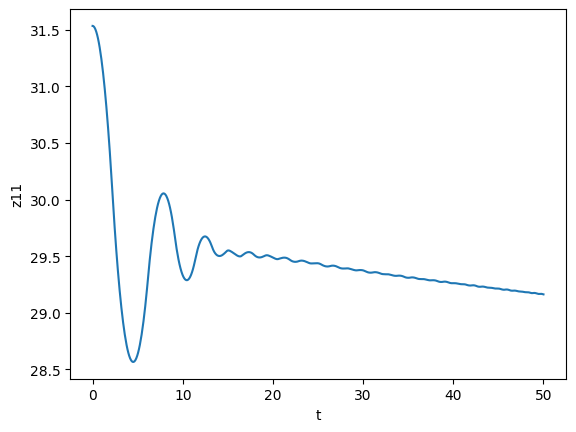

In [137]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

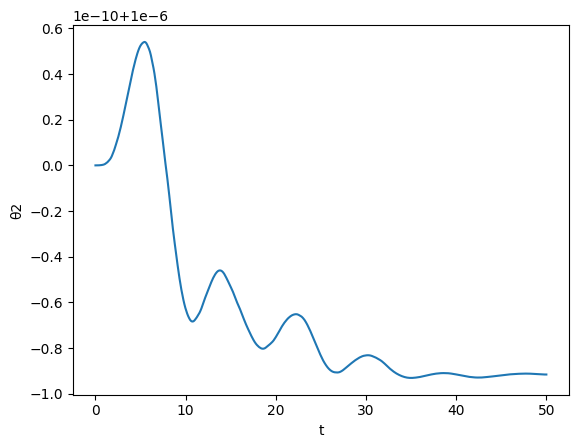

In [138]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

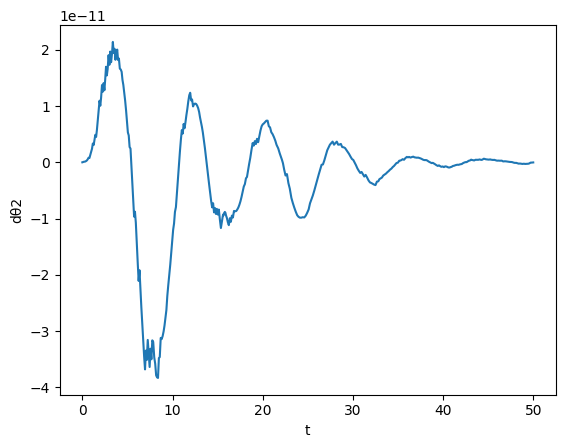

In [139]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

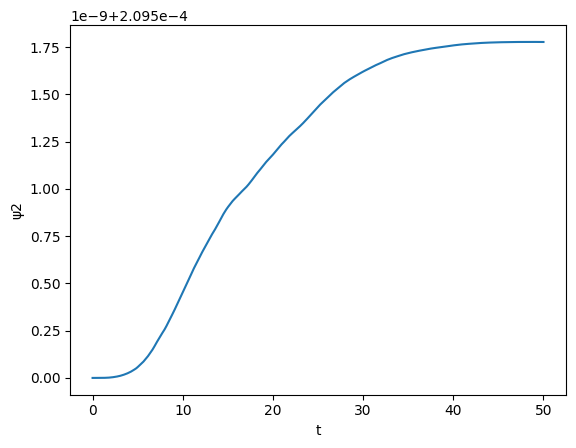

In [140]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

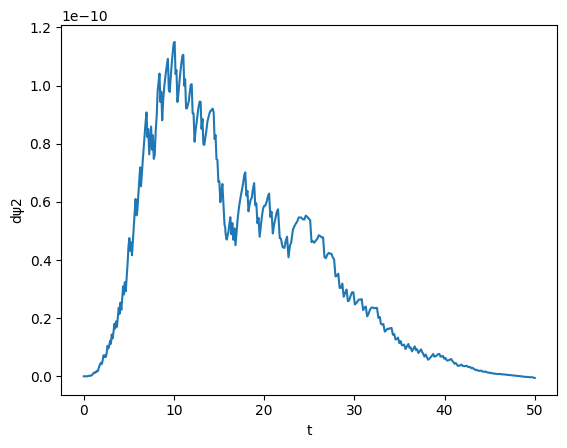

In [141]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

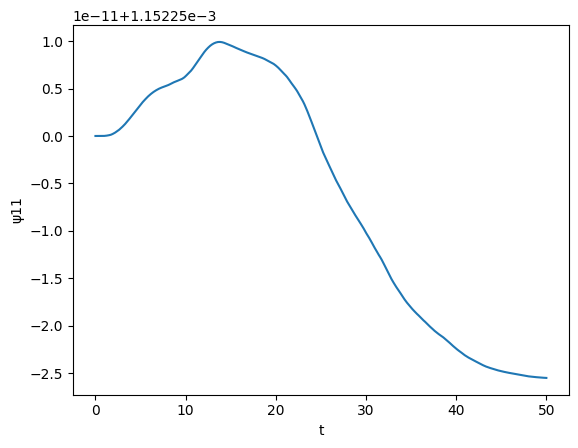

In [142]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()

In [143]:
X010=us.T[:,0*N:1*N]

In [144]:
Y010=us.T[:,2*N:3*N]

In [145]:
Z010=us.T[:,4*N:5*N]

In [146]:
simulation = np.stack([X010,Y010,Z010],axis=2) 

FPS = 30                      
frame_duration = 1000 / FPS

frames = []
for t in range(simulation.shape[0]):
    x = simulation[t,:,0]
    y = simulation[t,:,1]
    z = simulation[t,:,2]

    frames.append(go.Frame(
        data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode="lines+markers",
                marker=dict(size=5, color=list(range(12)), colorscale="Viridis"),
                line=dict(width=4)
            )
        ],
        name=f"t={t}"
    ))

# First frame
x0, y0, z0 = simulation[0,:,0], simulation[0,:,1], simulation[0,:,2]

fig = go.Figure(
    data=[go.Scatter3d(x=x0, y=y0, z=z0, mode="lines+markers")],
    frames=frames
)

# Animation controls
fig.update_layout(
    title="Pipeline Simulation ",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        xaxis=dict(range=[0, 300]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[0, 40]),
        aspectmode="data",
       
    ),
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": frame_duration, "redraw": True}}]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0}}]
            }
        ]
    }]
)

fig.show()